# About

This script generates the theoretical frequency and eigenvalue plots for the Kuramoto model with fixed, exponential delays.
Some important values regarding the generation of eigenvalues:
 - tol: Uses all mesh star points as initial value for fminsearch given |detlambda(z)| < tol
 - rerange, imrange: The interval to obtain the initial values for fminsearch for real part, imaginary part respectively.
 
Refer to matlab scripts 'sec3_exp_analysis.mat, sec3_exp_analysis2.mat' regarding generation of import files.
 

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files from Matlab
import_folder = 'sec3_exp_analysis'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)

filenames = os.listdir(dir_im)
filenames.remove('parameters.mat')
filenames.remove('detEstimates.mat')

# Import and compile data

## Parameters

In [3]:
dir_par = os.path.join(dir_im, 'parameters.mat')
dict_par = sio.loadmat(dir_par)

taum_arr = np.reshape(dict_par['taum'], -1)

N = dict_par['N'][0,0]
g = dict_par['g'][0,0]
w0 = dict_par['omega0'][0,0]

tol = dict_par['tol'][0,0]
rerange = np.reshape(dict_par['rerange'], -1)
imrange = np.reshape(dict_par['imrange'], -1)

## Compile arrays to plot

In [4]:
# Arrays over increasing taum (mean exponential delay)
eqOmegas = np.zeros(len(filenames))
leadReEigs = np.zeros(len(filenames))
leadReEigs_lim = np.zeros(len(filenames))
# taums = np.zeros(len(filenames)) # Check if this is equal to taum_arr

# Expected eigenvalue branches
eig1_arr = np.zeros(len(filenames), dtype='complex64')
eig2_arr = np.zeros(len(filenames), dtype='complex64')

# Indices to plot full eigenvalue distribution
ind1 = 3
ind2 = 11

zeroTol = 0.01
thr = 0.1 # Threshold for eigenvalue errors

# Acquire trials data
for i in range(len(filenames)):
    
    # Import .mat file
    filename = filenames[i]
    dir_mat = os.path.join(dir_im, filename)
    dict_mat =  sio.loadmat(dir_mat)
    
    # Get g, tau0 indices
    ind_file = filename.split('.')[0]
    ind = int(ind_file)
    taum = taum_arr[ind]
    
    # Eigenvalues
    eigs = dict_mat['found']
    errors = dict_mat['errors']
    
    # Only keep eigenvalues below error threshold
    eigs = eigs[errors < thr]
    errors = errors[errors < thr]
    eigs_nonzero = eigs[np.abs(eigs) > zeroTol]
    maxEig = np.max(eigs_nonzero.real)
    
    limiteigs = dict_mat['eigenvalues'] # Expected value of det
    leadReEigs_lim[ind] = np.max(np.real(limiteigs[np.abs(limiteigs) > zeroTol]))
    limEigsNonzero = limiteigs[np.abs(limiteigs) > zeroTol]
    
    # Eigenvalue branches
    if limEigsNonzero[0].real >= limEigsNonzero[1].real and limEigsNonzero.imag[0] >= 0:
        eig1_arr[ind] = limEigsNonzero[0]
        eig2_arr[ind] = limEigsNonzero[1]
    else:
        eig1_arr[ind] = limEigsNonzero[1]
        eig2_arr[ind] = limEigsNonzero[0]
        
    # Store
    eqOmegas[ind] = dict_mat['eqOmega'][0,0]
    leadReEigs[ind] = maxEig
    
    # If equal to an index, store the eigenvalue distribution
    if ind == ind1:
        dist1 = eigs
        dist1_limit = limiteigs
        dist1_errors = errors
        taum1 = taum
        
    elif ind == ind2:
        dist2 = eigs
        dist2_limit = limiteigs
        dist2_errors = errors
        taum2 = taum
        
# Get transition array (from real to complex roots)
mu_arr = 1 / taum_arr
coeff_arr = mu_arr**2 + eqOmegas**2 + 2*g*mu_arr**3 / (mu_arr**2 + eqOmegas**2) - g*mu_arr

# Figure 1

## Options

In [5]:
# Plot positions [left, bottom, width, height]
bbox0 = [0.10, 0.80, 0.30, 0.20] # Top left (error plot)
bbox1 = [0.10, 0.45, 0.30, 0.20] # Middle left (stability of expected eigenvalues)
bbox2 = [0.10, 0.10, 0.30, 0.20] # Bottom left (stability of actual eigenvalues)
bbox3 = [0.50, 0.10, 0.20, 0.90] # Right eig plot 1
bbox4 = [0.80, 0.10, 0.20, 0.90] # Right eig plot 2

# Alphas
alpha1 = 0.8
alpha_col = 0.2
alpha_w0 = 0.8

col1 = 'orange'
col2 = 'blue'
col_w0 = 'green'

# Linewidths
lw1 = 0.5
lw2 = 1.0

# Markers
m1 = 'x'
m2 = 's'

# Markersize
ms1 = 4

# S.log function
slog = lambda x: np.sign(x)*np.log10(1 + np.abs(x))

# Ticks
x_ticks = np.arange(0, np.max(taum_arr)+0.5, 1.0)

## Generate figure

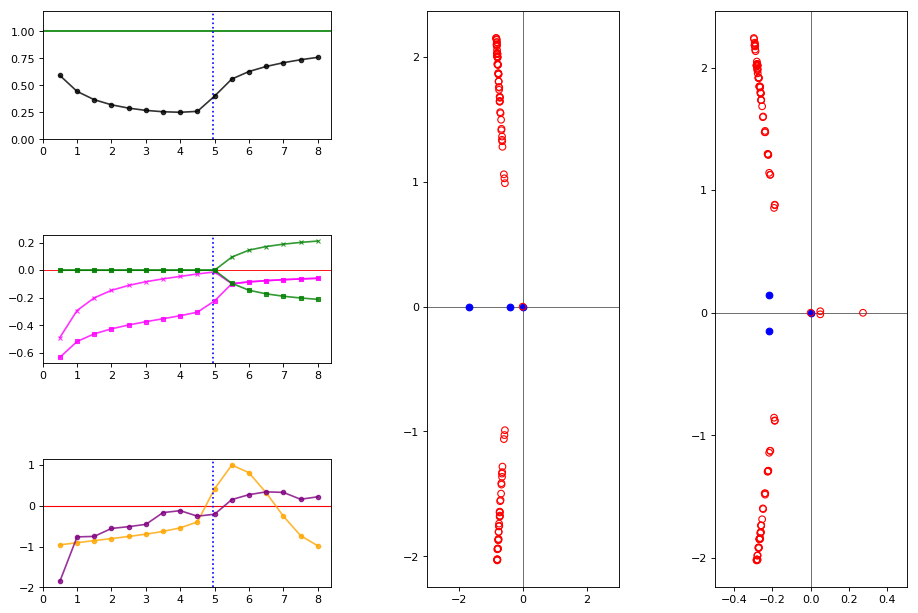

In [6]:
fig, ax = plt.subplots(5, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)

# Plot
ax[0].plot(taum_arr, eqOmegas, marker='o', ms=ms1, color='black', alpha=alpha1, zorder=2)

ax[1].plot(taum_arr, slog(eig1_arr.real), marker=m1, ms=ms1, color='magenta', alpha=alpha1, zorder=2)
ax[1].plot(taum_arr, slog(eig1_arr.imag), marker=m1, ms=ms1, color='green', alpha=alpha1, zorder=2)
ax[1].plot(taum_arr, slog(eig2_arr.real), marker=m2, ms=ms1, color='magenta', alpha=alpha1, zorder=2)
ax[1].plot(taum_arr, slog(eig2_arr.imag), marker=m2, ms=ms1, color='green', alpha=alpha1, zorder=2)

ax[2].plot(taum_arr, leadReEigs, marker='o', ms=ms1, color='purple', alpha=alpha1, zorder=2)
ax[2].plot(taum_arr, -np.cos(eqOmegas*taum_arr), marker='o', ms=ms1, color='orange', alpha=alpha1, \
           zorder=1)
# ax[1].plot(taum_arr, leadReEigs_lim, marker='o', color='orange', alpha=alpha1, zorder=2)

# Eigenvalues
ax[3].scatter(dist1.real, slog(dist1.imag), facecolors='none', edgecolors='red', zorder=2)
ax[3].scatter(dist1_limit.real, slog(dist1_limit.imag), color='blue', zorder=1)
ax[4].scatter(dist2.real, slog(dist2.imag), facecolors='none', edgecolors='red', zorder=2)
ax[4].scatter(dist2_limit.real, slog(dist2_limit.imag), color='blue', zorder=1)

# Axis lines
ax[0].axhline(y=w0, color=col_w0, zorder=0)
ax[1].axhline(y=0, color='red', linewidth=0.8, zorder=0)
ax[2].axhline(y=0, color='red', linewidth=1.0, zorder=0)

ax[3].axvline(x=0, color='black', linewidth=0.5, zorder=0)
ax[4].axvline(x=0, color='black', linewidth=0.5, zorder=0)
ax[3].axhline(y=0, color='black', linewidth=0.5, zorder=0)
ax[4].axhline(y=0, color='black', linewidth=0.5, zorder=0)

tauc = 4.94
ax[0].axvline(x=tauc, color='blue', ls='dotted', linewidth=1.5, zorder=1)
ax[1].axvline(x=tauc, color='blue', ls='dotted', linewidth=1.5, zorder=1)
ax[2].axvline(x=tauc, color='blue', ls='dotted', linewidth=1.5, zorder=1)

# Axis limits
ax[0].set_ylim(bottom=0, top=w0+g/8)
ax[3].set_xlim(left=-2*g, right=2*g)
ax[4].set_xlim(left=-0.5, right=0.5)
# ax[3].set_ylim(bottom=-20, top=20)
# ax[4].set_ylim(bottom=-20, top=20)

# Set ticks
ax[0].xaxis.set_ticks(x_ticks)
ax[1].xaxis.set_ticks(x_ticks)
ax[2].xaxis.set_ticks(x_ticks)

## Statistics

In [7]:
print(f'taum1 = {taum1}')
print(f'taum2 = {taum2}')
DIST1_error = np.log10(np.max(dist1_errors))
DIST2_error = np.log10(np.max(dist2_errors))
print(f'Max error of eigenvalues 1 = {DIST1_error}')
print(f'Max error of eigenvalues 2 = {DIST2_error}')

taum1 = 2.0
taum2 = 6.0
Max error of eigenvalues 1 = -4.19661391234031
Max error of eigenvalues 2 = -3.9179598376712326


# Figure 2

## Choose indices for $\tau^m$:

In [8]:
ind1 = 3
ind2 = 11

## Import numeric simulations

In [9]:
dir_est = os.path.join(dir_im, 'detEstimates.mat')
dict_est = sio.loadmat(dir_est)

# Get arrays
taum_arr2 = np.reshape(dict_est['taum'], -1)
Omega_arr2 = np.reshape(dict_est['Omega'], -1)
logz_arr = np.reshape(dict_est['logz'], -1)
z_arr = 10**(-logz_arr)

pvalues = dict_est['pvalues']
detMeans = dict_est['detMeans']
detVars = dict_est['detVars']

# Get specific arrays
abslog = lambda x: np.log10(np.abs(x))

pvalues1 = pvalues[ind1,:]
pvalues2 = pvalues[ind2,:]
detMeans1 = abslog(detMeans[ind1,:])
detstds1 = abslog(np.sqrt(detVars[ind1,:]))
detMeans2 = abslog(detMeans[ind2,:])
detstds2 = abslog(np.sqrt(detVars[ind2,:]))

## Mean and variances

In [10]:
# Theoretical Functions
muz = lambda z, mu, Omega: mu*(z + mu) / ((z + mu)**2 + Omega**2)
muz2 = lambda z, mu, Omega: 0.5*mu*((2*z + mu) / (4*Omega**2 + (2*z + mu)**2) + 1/(2*z + mu))
stdz = lambda z, mu, Omega: np.sqrt(muz2(z, mu, Omega) - (muz(z, mu, Omega))**2)
mu0 = lambda mu, Omega: mu**2 / (mu**2 + Omega**2)

# Fixed z arrays
z = 0.1

mu_arr = 1 / taum_arr2

beta_arr = g / (z + g*mu0(mu_arr, Omega_arr2))
mean_arr = beta_arr*muz(z, mu_arr, Omega_arr2)
std_arr = beta_arr*stdz(z, mu_arr, Omega_arr2)

# Varying z arrays
mu1 = 1 / taum_arr2[ind1]
mu2 = 1 / taum_arr2[ind2]
Omega1 = Omega_arr2[ind1]
Omega2 = Omega_arr2[ind2]

beta1_arr = g / (z_arr + g*mu0(mu1, Omega1))
beta2_arr = g / (z_arr + g*mu0(mu2, Omega2))

mean1_arr = beta1_arr*muz(z_arr, mu1, Omega1)
mean2_arr = beta2_arr*muz(z_arr, mu2, Omega2)

std1_arr = beta1_arr*stdz(z_arr, mu1, Omega1)
std2_arr = beta2_arr*stdz(z_arr, mu2, Omega2)

## Options

In [11]:
# Plot positions [left, bottom, width, height]
bbox0 = [0.10, 0.75, 0.37, 0.25] # Top left
bbox1 = [0.10, 0.42, 0.37, 0.18] # Bottom left 1
bbox2 = [0.10, 0.10, 0.37, 0.18] # Bottom left 2
bbox3 = [0.60, 0.60, 0.40, 0.40] # Top right
bbox4 = [0.60, 0.10, 0.40, 0.40] # Bottom right

# Markers
m1 = 'x'
m2 = 's'

# Sizes
ms0 = 5
ms1 = 6
ms2 = 6

# Colours:
mean_col = 'blue'
var_col = 'red'

det_col1 = 'purple'
det_col2 = 'magenta'

p_col1 = 'green'
p_col2 = 'black'

# Alphas
alpha1 = 0.8
alpha2 = 0.6

## Plot

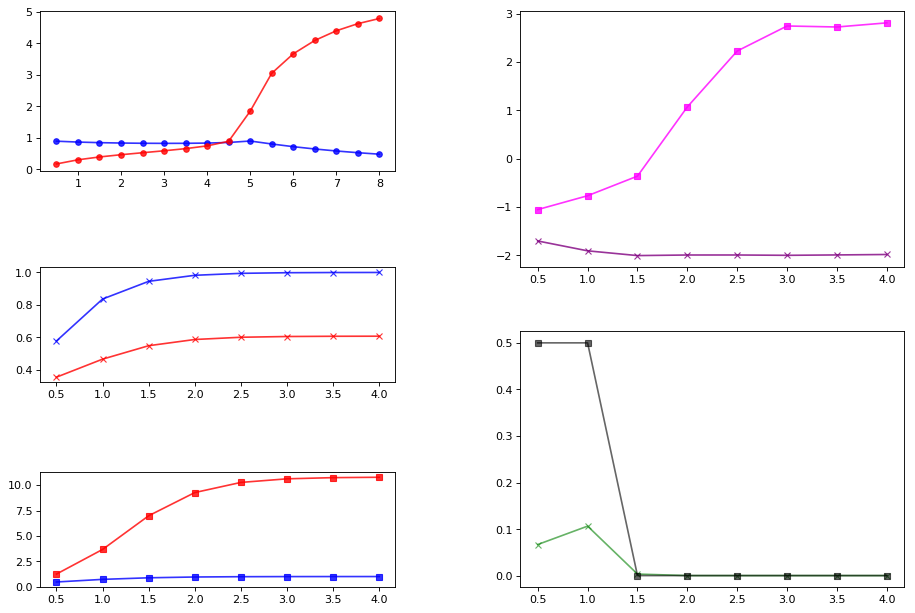

In [12]:
fig, ax = plt.subplots(5, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)

# Plot
ax[0].plot(taum_arr2, mean_arr, marker='o', ms=ms0, color=mean_col, alpha=alpha1, zorder=2)
ax[0].plot(taum_arr2, std_arr, marker='o', ms=ms0, color=var_col, alpha=alpha1, zorder=2)

ax[1].plot(logz_arr, mean1_arr, marker=m1, ms=ms1, color=mean_col, alpha=alpha1, zorder=2)
ax[1].plot(logz_arr, std1_arr, marker=m1, ms=ms1, color=var_col, alpha=alpha1, zorder=2)

ax[2].plot(logz_arr, std2_arr, marker=m2, ms=ms2, color=var_col, alpha=alpha1, zorder=2)
ax[2].plot(logz_arr, mean2_arr, marker=m2, ms=ms2, color=mean_col, alpha=alpha1, zorder=2)

ax[3].plot(logz_arr, detstds1, marker=m1, ms=ms1, color=det_col1, alpha=alpha1, zorder=2)
ax[3].plot(logz_arr, detstds2, marker=m2, ms=ms2, color=det_col2, alpha=alpha1, zorder=2)

ax[4].plot(logz_arr, pvalues1, marker=m1, ms=ms1, color=p_col1, alpha=alpha2, zorder=2)
ax[4].plot(logz_arr, pvalues2, marker=m2, ms=ms2, color=p_col2, alpha=alpha2, zorder=2)


# Statistics

In [13]:
print(f'taum1 = {taum1}')
print(f'taum2 = {taum2}')

taum1 = 2.0
taum2 = 6.0


In [14]:
z_arr

array([3.16227766e-01, 1.00000000e-01, 3.16227766e-02, 1.00000000e-02,
       3.16227766e-03, 1.00000000e-03, 3.16227766e-04, 1.00000000e-04])

In [15]:
np.max(dist1_errors), np.max(dist2_errors)

(6.358959919850015e-05, 0.0001207925535488425)